#### TASK 1.1: Importing Libraries

In [2]:
# !pip install lifetimes 
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, kstest
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler


Matplotlib is building the font cache; this may take a moment.


In [4]:
df_ = pd.read_csv('sample_customer_data.csv')
df = df_.copy()

#### TASK 1.2: Exploring the Data Distribution

To check whether the data follows a normal distribution, a function called "check_normality" is used. This function is designed to assess whether the numerical columns in the dataset conform to a normal distribution. The check is performed using the Shapiro-Wilk and Kolmogorov-Smirnov tests, and the results of the normality tests are reported for each column. However, a warning message is received stating, "p-value may not be accurate for N > 5000." This warning indicates that the results of the normality tests may not be accurate or reliable. The message suggests that when the dataset is of substantial size, the p-value calculation for normality tests may not be precise.

In [5]:
import warnings
warnings.filterwarnings("ignore")

def check_normality(data):
    numeric_columns = data.select_dtypes(include=['int', 'float'])  
    results = {}
    for col in numeric_columns.columns:
        shapiro_stat, shapiro_p = shapiro(numeric_columns[col])
        ks_stat, ks_p = kstest(numeric_columns[col], 'norm')

        if shapiro_p > 0.05 and ks_p > 0.05:
            results[col] = "Veri normal dağılıma uyar."
        else:
            results[col] = "Veri normal dağılıma uymaz."

    return results

result = check_normality(df)

print(result)

{'order_num_total_ever_online': 'Veri normal dağılıma uymaz.', 'order_num_total_ever_offline': 'Veri normal dağılıma uymaz.', 'customer_value_total_ever_offline': 'Veri normal dağılıma uymaz.', 'customer_value_total_ever_online': 'Veri normal dağılıma uymaz.'}


#### TASK 1.3: Data Visualization


For such cases, it's better to rely on visual analyses rather than completely trusting the results of normality tests. Methods like histograms, Q-Q plots, and normal distribution curves better illustrate how well the data adheres to a normal distribution and are more reliable for larger datasets. The function named "num_graph" draws histograms and normal distribution curves for numerical columns in the dataset, which is used to visualize the data's distribution. Since our dataset is larger than 5000, these visual analyses will help us obtain more reliable insights.

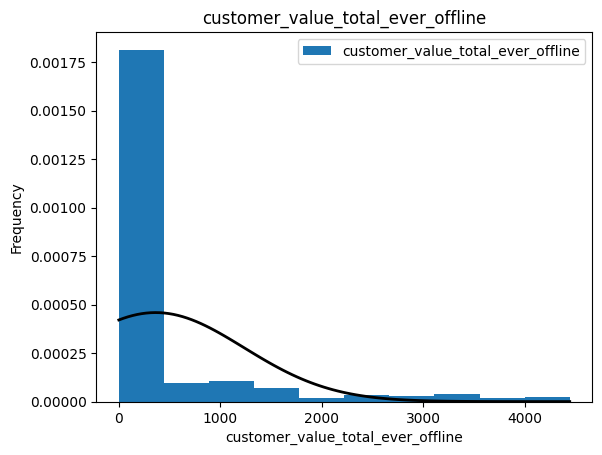

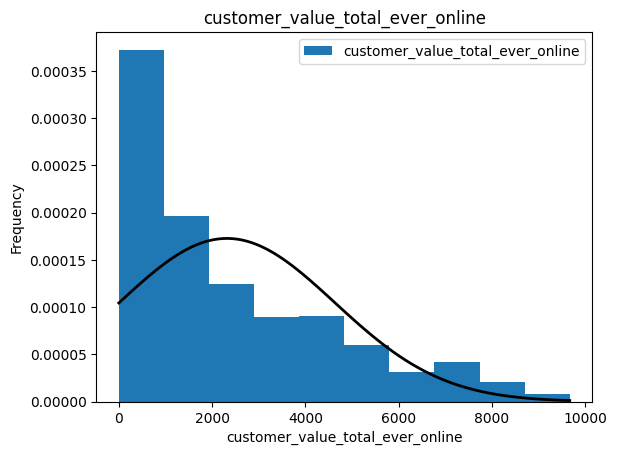

In [6]:
def num_graph(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype in [int, float]:
            data = dataframe[[col]]  
            if data.dtypes[0] == 'float':
                data = data.dropna()
                data.plot(kind='hist', density=True, title=col) 
                data_mean, data_std = data.mean(), data.std()
                xmin, xmax = data.min(), data.max()
                x = np.linspace(xmin, xmax, 100)
                p = norm.pdf(x, data_mean, data_std) 
                plt.plot(x, p, 'k', linewidth=2)  
                plt.xlabel(col)
                plt.show()
                # print(f"{col} Result of the normality test: {check_normality(data)}")

num_graph(df)

#### TASK 1.4: Handling Outliers in the Dataset

{'order_num_total_ever_online': 'Veri normal dağılıma uymaz.', 'order_num_total_ever_offline': 'Veri normal dağılıma uymaz.', 'customer_value_total_ever_offline': 'Veri normal dağılıma uymaz.', 'customer_value_total_ever_online': 'Veri normal dağılıma uymaz.'}


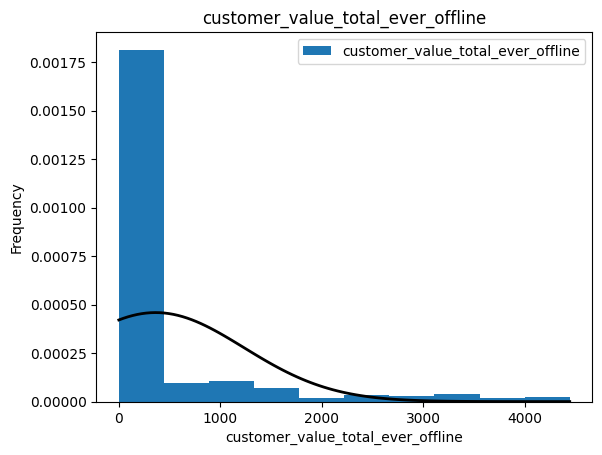

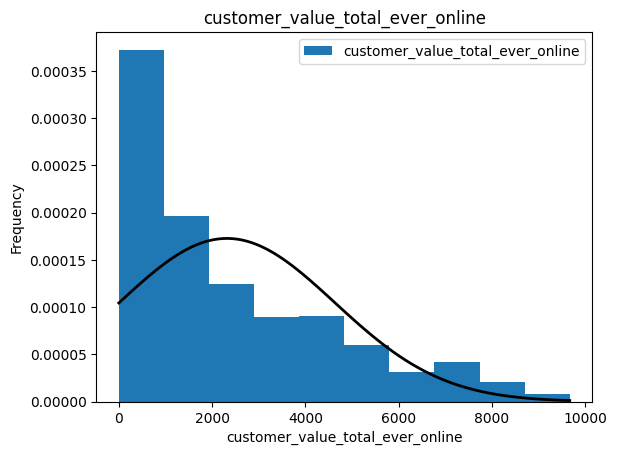

In [7]:
df.head()
df.dtypes


"""
A "variable_list" is created for the variables in the DataFrame that need to be capped.
"""

variable_list = ["order_num_total_ever_online",
                "order_num_total_ever_offline",
                "customer_value_total_ever_offline",
                "customer_value_total_ever_online"]

"""
A function called "outlier_thresholds" is created to perform the process of handling 
outliers by capping them at specified thresholds. 
"""

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = (quartile3 + 1.5 * interquantile_range).round()
    low_limit = (quartile1 - 1.5 * interquantile_range).round()
    return low_limit, up_limit


"""
A DataFrame is created, and the variable "replace_with_thresholds" is generated after 
handling the outliers.
"""
def replace_with_thresholds(dataframe, variable_list):
    for variable in variable_list:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    new_result = check_normality(df)
    print(new_result)

replace_with_thresholds(df, variable_list)

"""
After handling the outliers in the dataset, the "num_graph" function is used to draw 
updated histograms and normal distribution curves for numerical columns.
"""

num_graph(df)


#### TASK 1.5: Data Preprocessing and Feature Engineering

In [8]:
"""
OmniChannel refers to customers making purchases from both online and offline platforms. New variables
are created for each customer's total number of purchases and spending. Variables representing dates 
are converted to the "date" type.
"""

df['TotalPurchaseCount'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['TotalSpending'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

date_columns = ['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

### TASK 2: CREATING CLTV METRICS

In [11]:
"""
To create the observation date, add 2 days to the last purchase date.
"""

df['last_order_date'].max()
today_date = dt.datetime(2021, 6, 1)

cltv = pd.DataFrame()
cltv["customer_id"] = df["master_id"]
cltv["recency"] = ((df["last_order_date"] - df["first_order_date"]) / 7).dt.days
cltv["T_score"] = ((today_date - df["first_order_date"]) / 7).dt.days
cltv["frequency"] = df["TotalPurchaseCount"]
cltv["monetary"] = df["TotalSpending"] / cltv["frequency"]

### TASK 3: ESTABLISHING BG/NBD AND GAMMA-GAMMA MODELS

* TASK 3.1: Establishing the BG/NBD Model
* TASK 3.2: Establishing the Gamma-Gamma Model
* TASK 3.3: Observing Based on CLTV Value

#### TASK 3.1: Establishing the BG/NBD Model

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv['frequency'],
        cltv['recency'],
        cltv['T_score'])

# <lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 75.49, b: 0.00, r: 3.65>

ValueError: Some values in recency vector are larger than T vector.

#### TASK 3.2: Establishing the Gamma-Gamma Model

In [9]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv['frequency'], cltv['monetary'])

# <lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08> 

ggf.conditional_expected_average_profit(cltv['frequency'],
                                        cltv['monetary']).sort_values(ascending=False)
cltv["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv['frequency'],
                                                                          cltv['monetary'])
cltv.sort_values("expected_average_profit", ascending=False)

,customer_id,recency,T_score,frequency,monetary,expected_average_profit
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2,7,4.0000,1401.8000,1449.0605
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51,101,7.0000,1106.4671,1127.6115
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63,83,4.0000,1090.3600,1127.3545
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8,9,2.0000,862.6900,923.6800
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57,94,2.0000,859.5800,920.3579
...,...,...,...,...,...,...
3096,4bb3a040-acc9-11e9-a2fc-000d3a38a36f,136,159,3.0000,26.8233,29.4348
7693,1e2dd6cc-0b1e-11eb-8ffc-000d3a38a36f,20,33,2.0000,24.9900,28.8713
14980,0769f8d0-d627-11e9-93bc-000d3a38a36f,58,93,2.0000,22.4900,26.2008
1710,08b95b62-a987-11e9-a2fc-000d3a38a36f,226,232,2.0000,22.4900,26.2008


#### TASK 3.3: Observing Based on CLTV Value

In [10]:
"""
Predict the expected purchases from customers within 3 months.
"""
cltv["exp_sales_3_month"] = bgf.predict(4*3,
                                        cltv['frequency'],
                                        cltv['recency'],
                                        cltv['T_score'])
cltv.head()

"""
Predict the expected purchases from customers within 6 months.
"""
cltv["exp_sales_6_month"] = bgf.predict(4*6,
                                        cltv['frequency'],
                                        cltv['recency'],
                                        cltv['T_score'])

cltv.head()

"""

Examine the top 10 individuals who will make the most purchases in the 3rd and 6th months.
"""

cltv["exp_sales_3_month"].head(10)
cltv["exp_sales_6_month"].head(10)

0   1.9678
1   1.9753
2   1.3524
3   1.4199
4   0.7953
5   0.7691
6   1.3161
7   1.0471
8   1.4268
9   0.7906
Name: exp_sales_6_month, dtype: float64

In [11]:
"""
Calculate the 6-month CLTV and add it to the dataframe with the name "CLTV."
"""

CLTV = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T_score'],
                                   cltv['monetary'],
                                   time=6,  # 3 Months
                                   freq="W",  # Frequency information for T.
                                   discount_rate=0.01)
cltv['CLTV'] = CLTV

"""
Observe the top 20 individuals with the highest CLTV value.
"""

cltv.sort_values("CLTV", ascending=False).head(20)

,customer_id,recency,T_score,frequency,monetary,expected_average_profit,exp_sales_3_month,exp_sales_6_month,CLTV
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2,7,4.0000,1401.8000,1449.0605,1.1127,2.2255,3383.6163
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6,13,11.0000,758.0855,767.3606,1.9865,3.9731,3198.8405
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51,101,7.0000,1106.4671,1127.6115,0.7241,1.4481,1713.3248
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74,74,16.0000,501.8737,506.1667,1.5773,3.1546,1675.3408
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62,67,52.0000,166.2246,166.7123,4.6865,9.3730,1639.5120
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3,34,8.0000,601.2262,611.4926,1.2767,2.5535,1638.2908
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8,9,2.0000,862.6900,923.6800,0.8024,1.6047,1555.2097
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9,13,17.0000,259.8653,262.0729,2.8002,5.6003,1539.9342
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52,58,31.0000,228.5300,229.6069,3.1147,6.2295,1500.7307
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14,15,3.0000,743.5867,778.0504,0.8818,1.7635,1439.6605


### TASK 4: CREATING SEGMENTS BASED ON CLTV

In [12]:
cltv["cltv_segment"] = pd.qcut(cltv["CLTV"], 4, labels=["D", "C", "B", "A"])
cltv.head()

"""
Examine the averages of recency, frequency, and monetary values for the segments.
"""

cltv.groupby("cltv_segment").agg({"recency": "mean",
                                  "frequency": "mean",
                                  "monetary": "mean"})

,recency,frequency,monetary
cltv_segment,,,
D,138.7121,3.7700,93.2319
C,92.2310,4.4065,125.8636
B,81.5068,5.0979,160.4792
A,66.8907,6.6384,228.8331


### TASK 5: FORMULATING HYPOTHESES AND TESTING THE HYPOTHESIS

* TASK 5.1: Formulating the Hypothesis
* TASK 5.2: Establishing the BG/NBD Model Related to the Hypothesis
* TASK 5.3: Establishing the Gamma-Gamma Model Related to the Hypothesis
* TASK 5.4: Segmenting the Periods Related to the Hypothesis
* TASK 5.5: Confirming the Hypothesis

### TASK 5.1: Formulating the Hypothesis

HYPOTHESES:

H0 (Null Hypothesis): Customer segments do not exhibit any statistically significant differences between 3, 6, 9, and 12-month CLTV calculations; in other words, customer segments have not changed over these four quarterly periods. The model is correct.

H1 (Alternate Hypothesis): Customer segments exhibit statistically significant differences in at least one of the periods of 3, 6, 9, and 12-month CLTV calculations; in other words, customer segments have changed over these four quarterly periods. The model is incorrect.

### TASK 5.2: Establishing the BG/NBD Model Related to the Hypothesis

In [13]:
CLTV_SEG_MARKETING = pd.DataFrame()
CLTV_SEG_MARKETING["CUSTOMER_ID"] = cltv["customer_id"]


CLTV_SEG_MARKETING["exp_sales_3_month"] = bgf.predict(4*3,
                                        cltv['frequency'],
                                        cltv['recency'],
                                        cltv['T_score'])
CLTV_SEG_MARKETING.head()


CLTV_SEG_MARKETING["exp_sales_6_month"] = bgf.predict(4*6,
                                        cltv['frequency'],
                                        cltv['recency'],
                                        cltv['T_score'])
CLTV_SEG_MARKETING.head()

CLTV_SEG_MARKETING["exp_sales_9_month"] = bgf.predict(4*9,
                                        cltv['frequency'],
                                        cltv['recency'],
                                        cltv['T_score'])
CLTV_SEG_MARKETING.head()

CLTV_SEG_MARKETING["exp_sales_12_month"] = bgf.predict(4*12,
                                        cltv['frequency'],
                                        cltv['recency'],
                                        cltv['T_score'])
CLTV_SEG_MARKETING.head()

,CUSTOMER_ID,exp_sales_3_month,exp_sales_6_month,exp_sales_9_month,exp_sales_12_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,0.9839,1.9678,2.9517,3.9356
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,0.9876,1.9753,2.9629,3.9506
2,69b69676-1a40-11ea-941b-000d3a38a36f,0.6762,1.3524,2.0286,2.7048
3,1854e56c-491f-11eb-806e-000d3a38a36f,0.7099,1.4199,2.1298,2.8397
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,0.3976,0.7953,1.1929,1.5905


### TASK 5.3: Establishing the Gamma-Gamma Model Related to the Hypothesis

In [14]:
CLTV_3 = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T_score'],
                                   cltv['monetary'],
                                   time=3,  # 3 Months
                                   freq="W",  # Frequency information for T.
                                   discount_rate=0.01)
CLTV_SEG_MARKETING['CLTV_3'] = CLTV_3


CLTV_6 = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T_score'],
                                   cltv['monetary'],
                                   time=6,  # 6 Months
                                   freq="W",  # Frequency information for T.
                                   discount_rate=0.01)
CLTV_SEG_MARKETING['CLTV_6'] = CLTV_6

CLTV_9 = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T_score'],
                                   cltv['monetary'],
                                   time=9,  # 9 Months
                                   freq="W",  # Frequency information for T.
                                   discount_rate=0.01)
CLTV_SEG_MARKETING['CLTV_9'] = CLTV_9

CLTV_12 = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T_score'],
                                   cltv['monetary'],
                                   time=12,  # 12 Months
                                   freq="W",  # Frequency information for T.
                                   discount_rate=0.01)
CLTV_SEG_MARKETING['CLTV_12'] = CLTV_12

#### TASK 5.4: Segmenting the Periods Related to the Hypothesis

In [15]:
CLTV_SEG_MARKETING["SEGMENT_3"] = pd.qcut(CLTV_SEG_MARKETING["CLTV_3"], 4, labels=["D", "C", "B", "A"])
CLTV_SEG_MARKETING["SEGMENT_6"] = pd.qcut(CLTV_SEG_MARKETING["CLTV_6"], 4, labels=["D", "C", "B", "A"])
CLTV_SEG_MARKETING["SEGMENT_9"] = pd.qcut(CLTV_SEG_MARKETING["CLTV_9"], 4, labels=["D", "C", "B", "A"])
CLTV_SEG_MARKETING["SEGMENT_12"] = pd.qcut(CLTV_SEG_MARKETING["CLTV_12"], 4, labels=["D", "C", "B", "A"])

#### TASK 5.5: Confirming the Hypothesis

In [16]:
result = True

for CUSTOMER_ID in CLTV_SEG_MARKETING['CUSTOMER_ID'].values:
    SEGMENT_3 = CLTV_SEG_MARKETING[CLTV_SEG_MARKETING['CUSTOMER_ID'] == CUSTOMER_ID]['SEGMENT_3'].values[0]
    SEGMENT_6 = CLTV_SEG_MARKETING[CLTV_SEG_MARKETING['CUSTOMER_ID'] == CUSTOMER_ID]['SEGMENT_6'].values[0]
    SEGMENT_9 = CLTV_SEG_MARKETING[CLTV_SEG_MARKETING['CUSTOMER_ID'] == CUSTOMER_ID]['SEGMENT_9'].values[0]
    SEGMENT_12 = CLTV_SEG_MARKETING[CLTV_SEG_MARKETING['CUSTOMER_ID'] == CUSTOMER_ID]['SEGMENT_12'].values[0]

    if (SEGMENT_3 == SEGMENT_6) and (SEGMENT_6 == SEGMENT_9) and (SEGMENT_9 == SEGMENT_12):
        pass
    else:
        result = False

print(result)

CLTV_SEG_MARKETING["SEGMENT"] = CLTV_SEG_MARKETING["SEGMENT_3"]

True


### TASK 6: CREATING STRATEGIES FOR CUSTOMER SEGMENTS

The hypothesis has been confirmed, and the model's accuracy has also been verified. Customer segments have been successfully predicted, providing valuable insights into customer shopping habits. Strategies are being formulated based on these segments, and plans are in place to send tailored and effective messages to customers. These strategies will be used to encourage customer purchases, ultimately boosting results.

In [17]:
campaigns = {
    "A": "For segment A, we are offering exclusive opportunities to our customers by pre-ordering our brand's new Limited Edition products.",
    "B": "For segment B, we are offering a special 20% discount on selected products!",
    "C": "For segment C, we are offering the opportunity to earn a 50 TL gift voucher for every 500 TL spent on purchases.",
    "D": "For segment D, we are welcoming customers with a 10% discount through our Welcome campaign!"
}


"""
Assign the appropriate campaign message to each customer.
"""

CLTV_SEG_MARKETING['Campaign_Message'] = CLTV_SEG_MARKETING['SEGMENT'].map(campaigns)

CLTV_SEG_MARKETING[['CUSTOMER_ID', 'SEGMENT', 'Campaign_Message']]

"""
The marketing department is requesting a CSV file that includes the 'CUSTOMER_ID,' 'SEGMENT,' and 'Campaign_Message' variables.
"""

MARKETING = CLTV_SEG_MARKETING[['CUSTOMER_ID', 'SEGMENT', 'Campaign_Message']]
MARKETING.to_csv("MARKETING", index=False)